In [1]:
import numpy as np
%cd /home/jeroen/repos/traffic-scheduling/
from network.generate_network import generate_grid_network
from network.exact import solve
from network.exact_online import solve_online
from network.util import draw_network, draw_vehicles, current_edge, as_dict, plot_schedule, dist, pos_along_route

/home/jeroen/repos/traffic-scheduling


We want to simulate the current schedule forward to an arbitrary time in the future. We need this to model the online scheduling setting, in which we need to simulate until the next arrival to the system. At such a point in time, the controller may adapt the current schedule, under some constraints, and then we simulate again until the next arrival.

## Example instance

Generate some example network and example instance to play with.

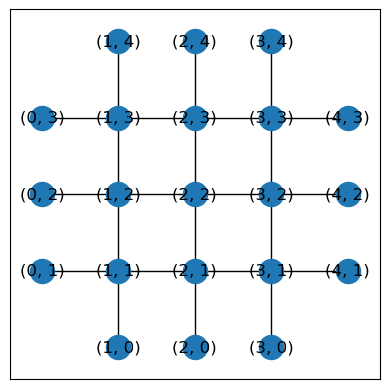

In [2]:
G, routes = generate_grid_network(3, 3)
draw_network(G)

In [3]:
vehicle_l = 2
vehicle_w = 1

N = len(routes)
n = [7 for _ in range(N)]

gap1 = 10
gap2 = 20

rng = np.random.default_rng()

def lane(n):
    length = np.repeat(vehicle_l, n)
    gaps = rng.uniform(gap1, gap2, size=(n))
    
    shifted = np.roll(length, 1); shifted[0] = 0
    release = np.cumsum(gaps + shifted)
    return release, length

releases, lengths = [], []
for l in range(N):
    rs, ls = lane(n[l])
    releases.append(rs); lengths.append(ls)

instance = {
    'G': G,
    'route': routes,
    'switch': vehicle_w,
    'release': releases,
    'length': lengths,
}

## Simulate schedule

We assume $v_\max = 1$, so distance is equivalent to time. Furthermore, we assume that routes are edge-disjoint, which makes computing the predecessor of a vehicle much less complicated: given a vehicle $(l,k)$, its predecessor is $(l,k-1)$, if it exists. We just update the vehicles in order of decreasing values of the $k$-index.

In [4]:
from operator import itemgetter

def vehicles(indices):
    """Get list of vehicles indices ordered by class and lane order."""
    v = indices
    v = sorted(v, key=itemgetter(0))
    v = sorted(v, key=itemgetter(1))
    return v

In [5]:
def simulate(G, routes, y, positions, dt):
    """Simulate current schedule y at time t forward over dt time units by modifying positions in-place."""
    for l, k in vehicles(positions.keys()):
        route = routes[l]
        if dt >= y[l, k, route[-1]]:
            # vehicle has reached the final node, so remove
            del positions[l, k]
            continue
        
        u, v, pos = current_edge(G, route, positions[l, k])
        i = route.index(v)
        
        # find destination edge (last_node, next_node)
        while y[l, k, route[i]] < dt:
            i += 1             
        next_node = route[i]
        
        if next_node == v:
            # still same edge
            positions[l, k] += min(dt, dist(G, u, v) - pos)
        else:
            # at least one intersection crossed
            last_node = route[i-1]
            positions[l, k] = pos_along_route(G, route, last_node) + min(dt - y[l, k, last_node], dist(G, last_node, next_node))
        
        # Find the position of the vehicle ahead, which has already been processed
        # due to the order computed by vehicle_order().
        # Edge-Disjoint Routes Assumption => predecessor is just (l, k-1), if it exists        
        if k > 0 and (l, k - 1) in positions:
            positions[l, k] = min(positions[l, k], positions[l, k - 1] - vehicle_l)

        # keep non-negative, also when not yet arrived
        positions[l, k] = max(0, positions[l, k])

## Online control with re-optimization

Release time of a vehicle indicates when the vehicle arrives to the network and can be considered in the planning. Therefore, we need a discrete-event simulation to loop through the arrivals. This just means we sort the release dates and loop over them.

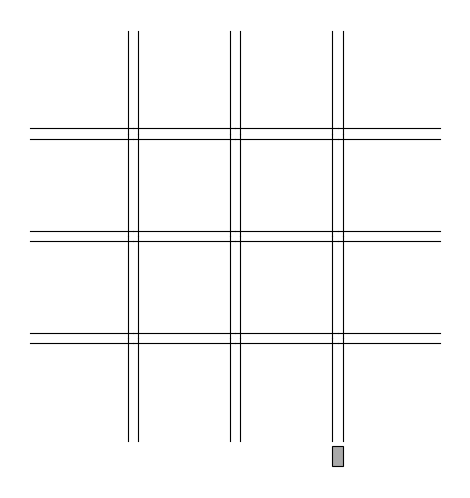

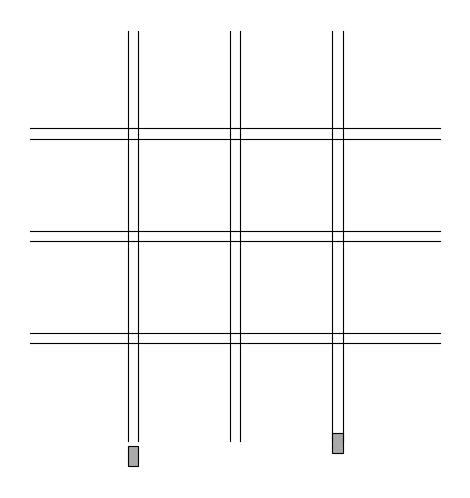

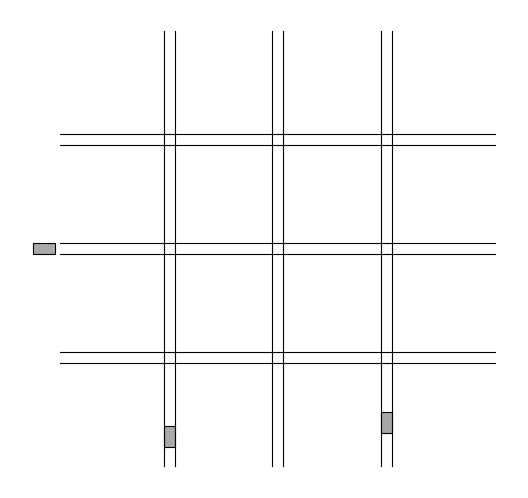

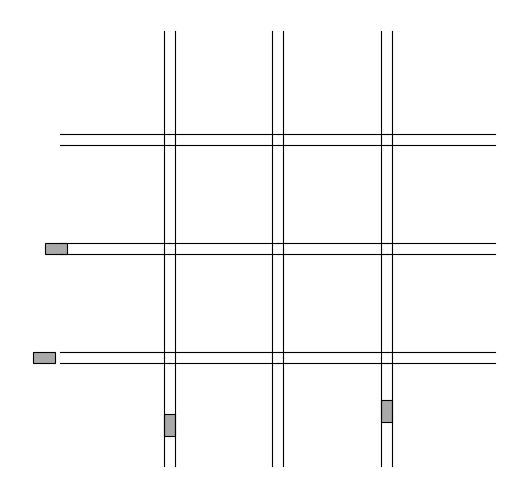

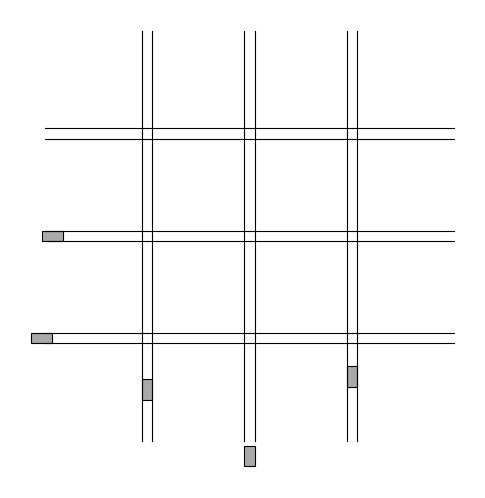

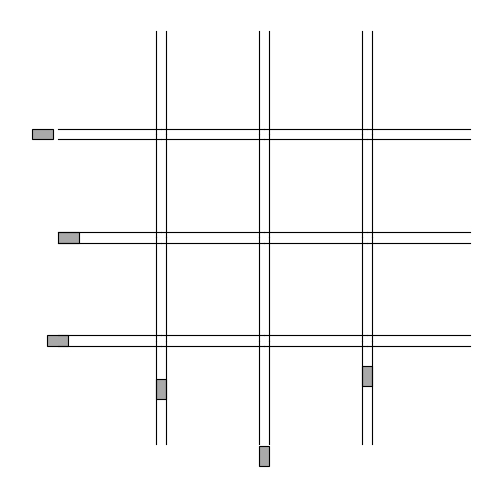

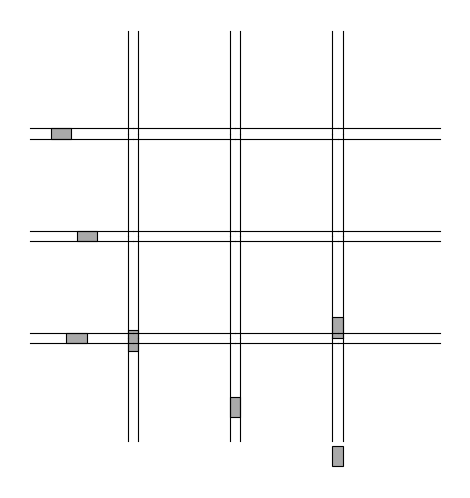

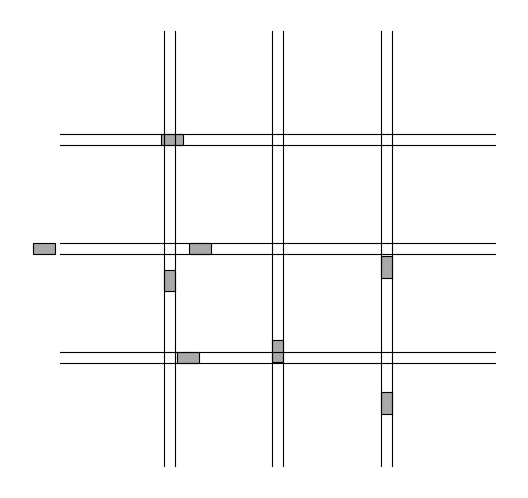

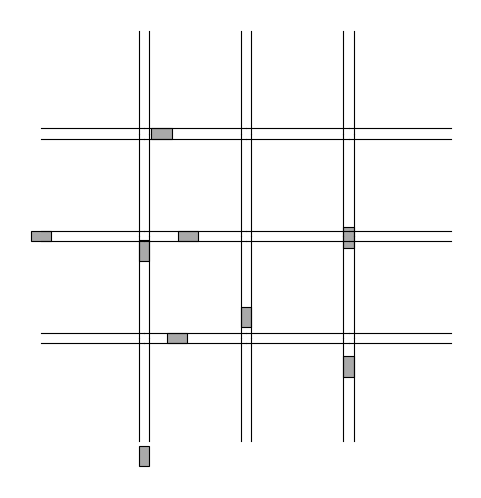

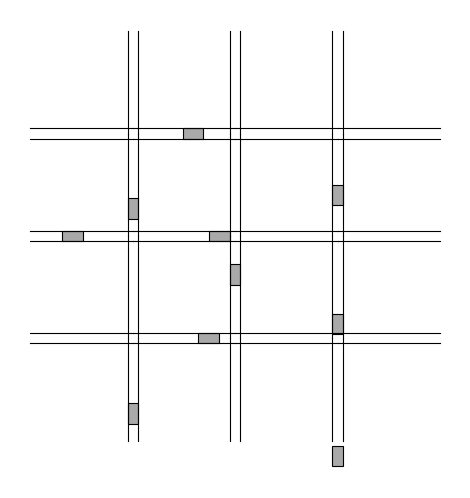

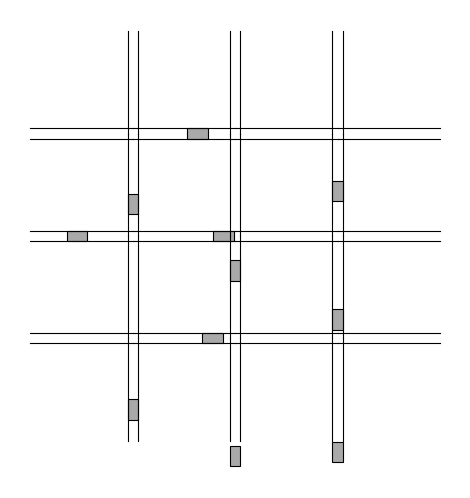

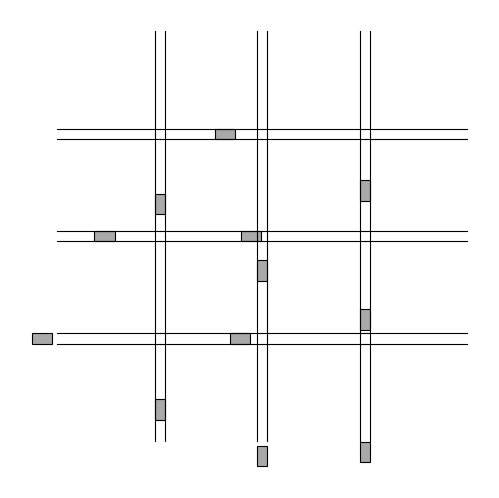

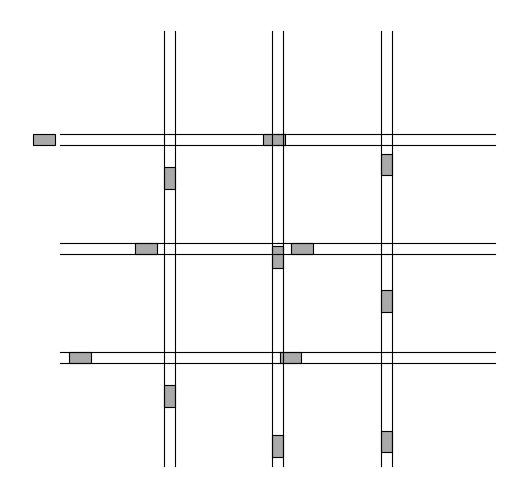

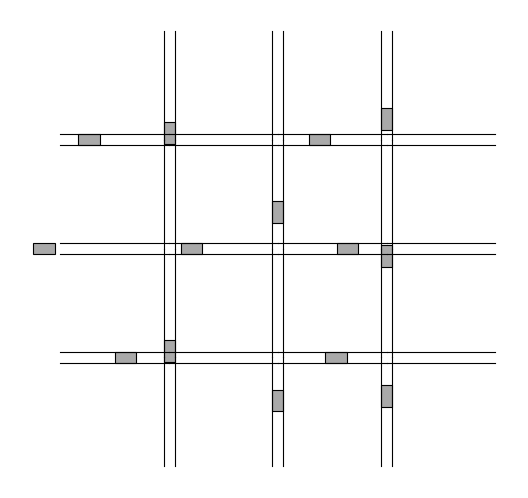

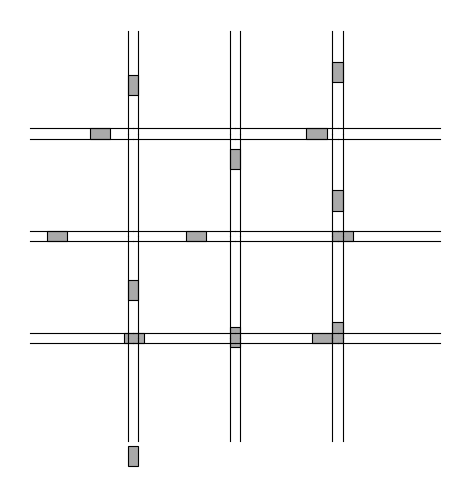

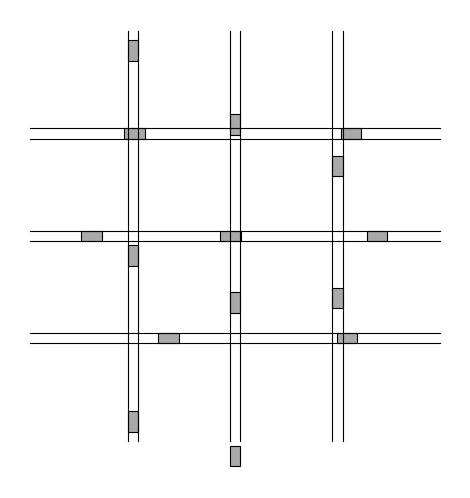

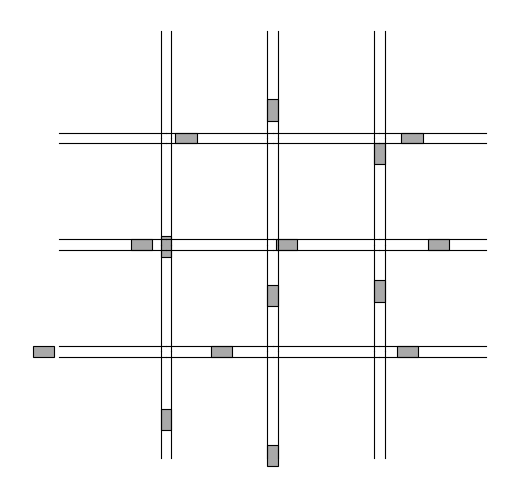

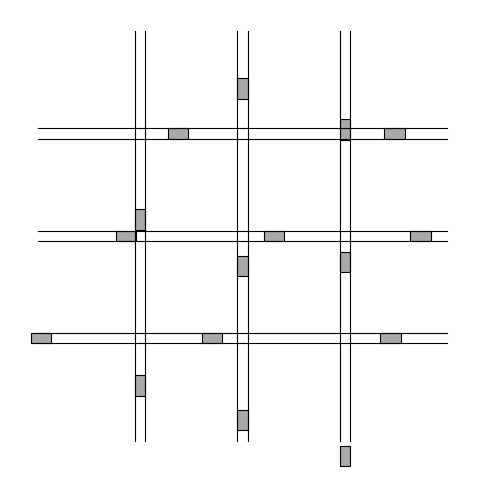

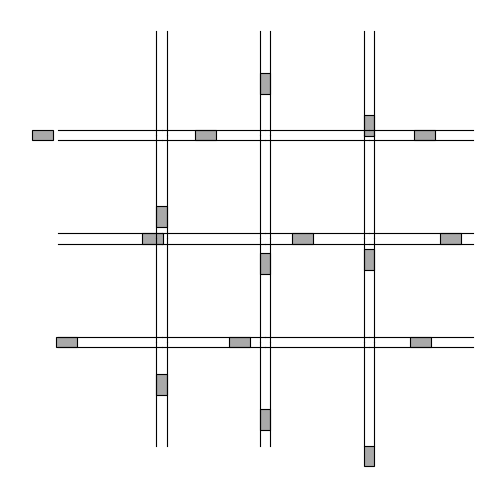

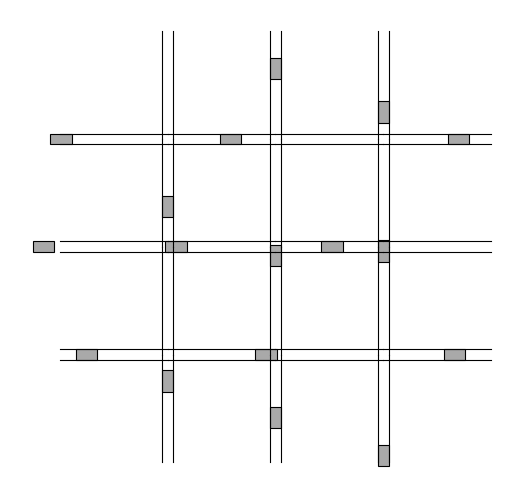

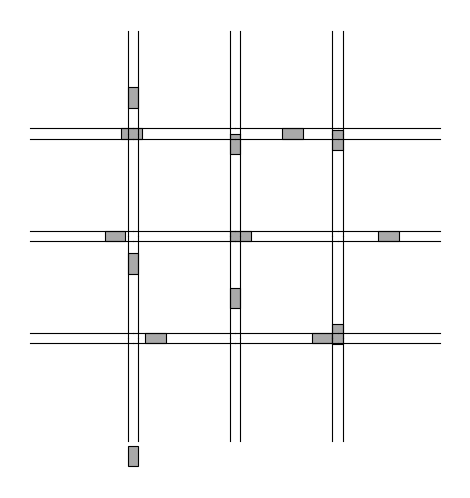

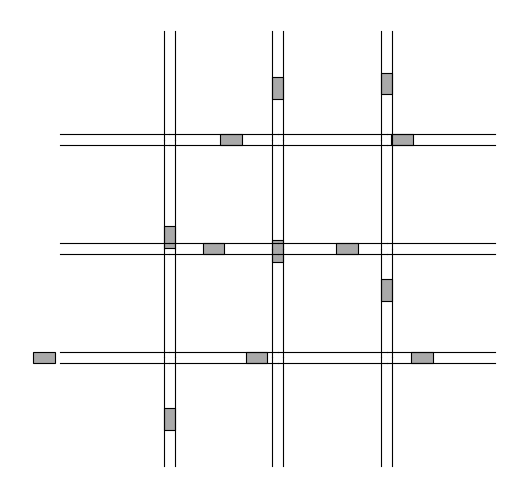

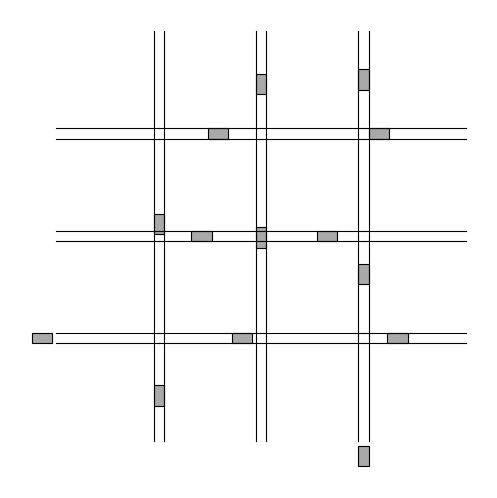

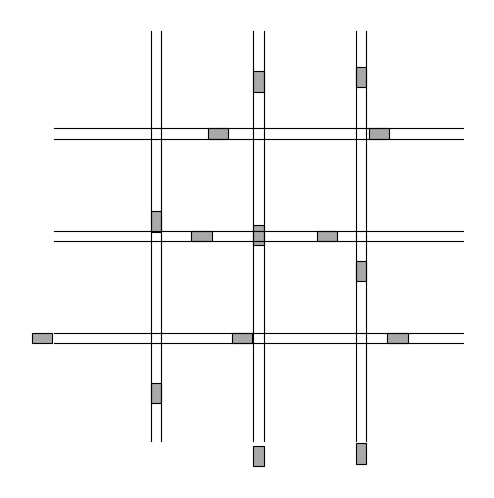

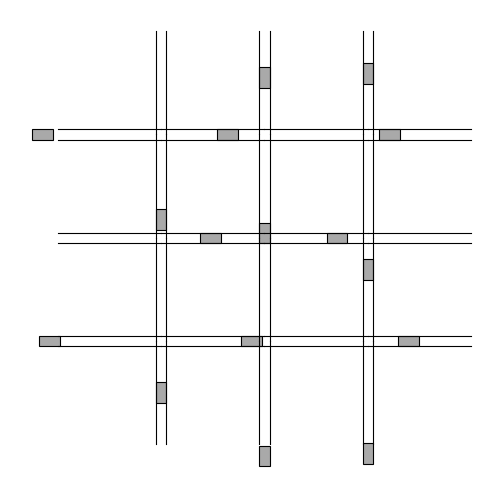

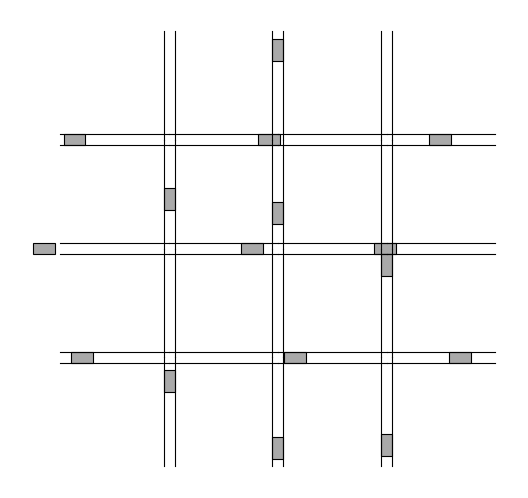

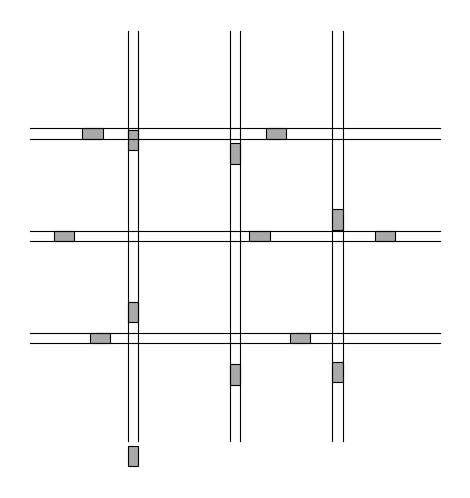

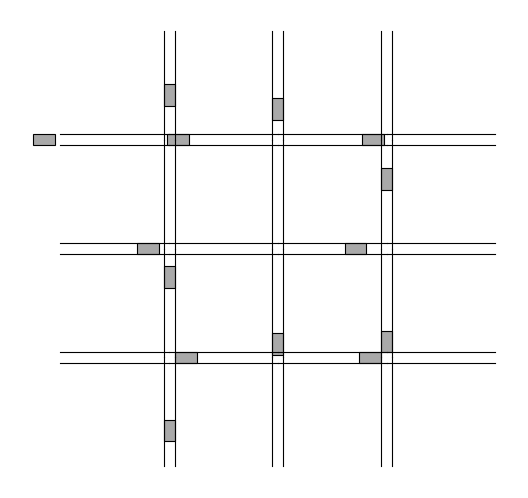

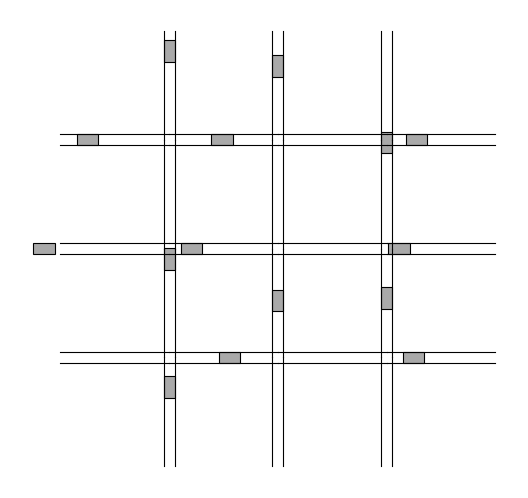

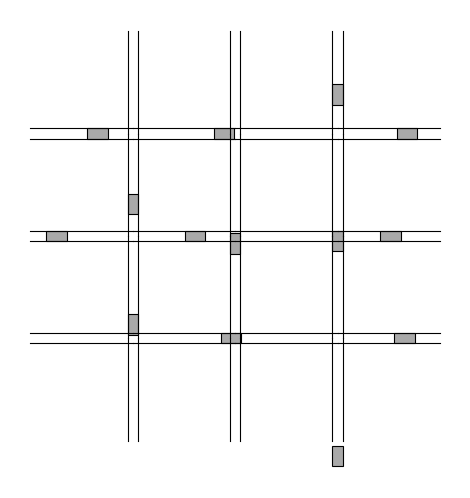

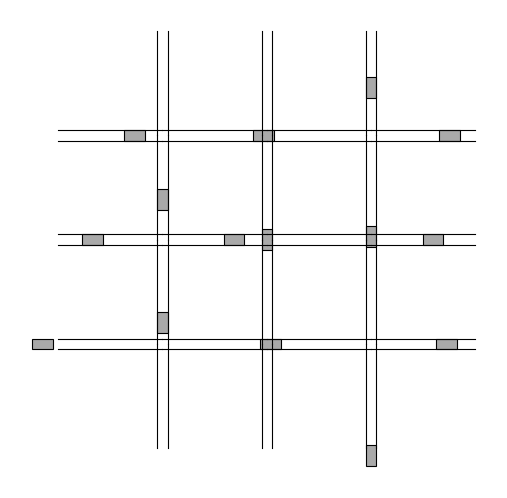

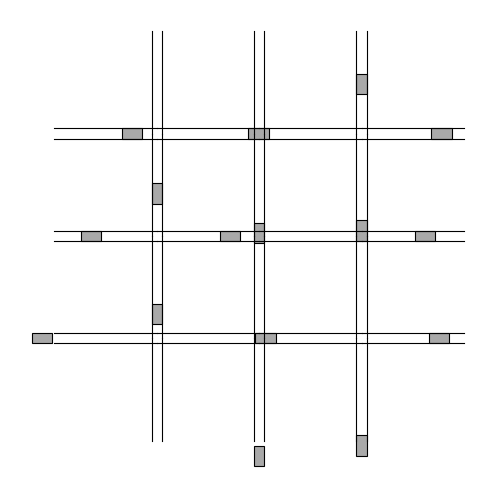

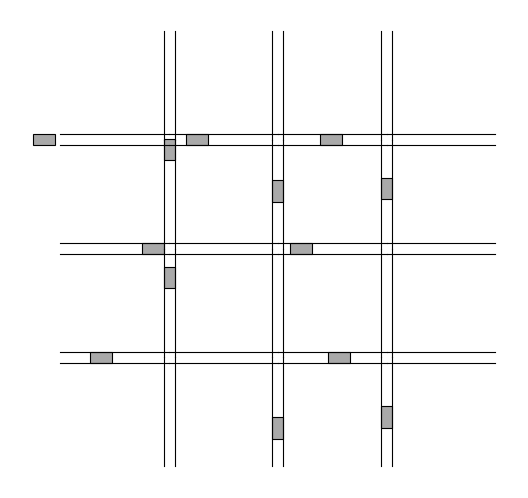

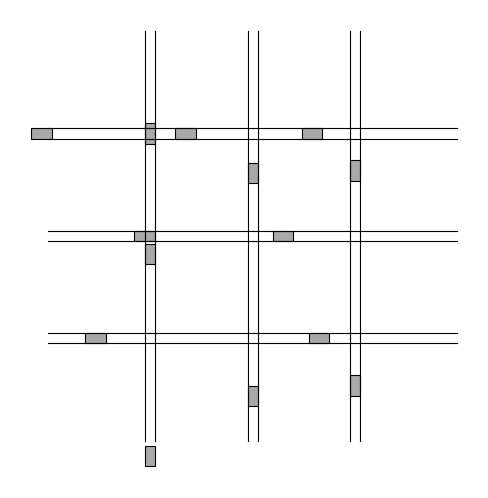

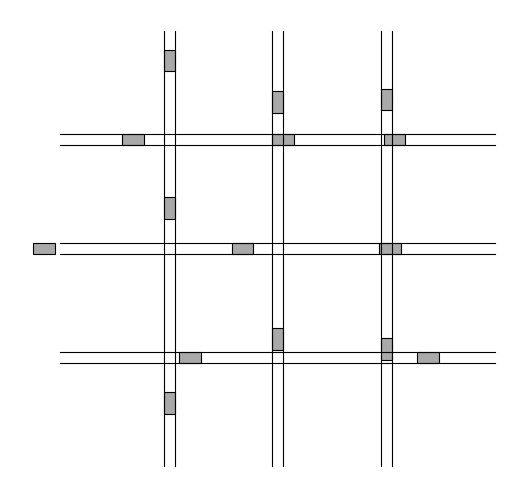

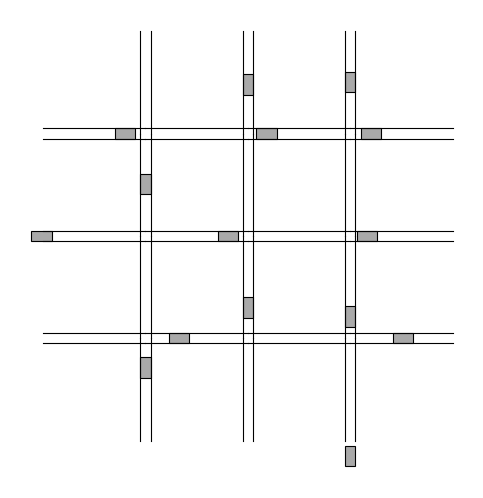

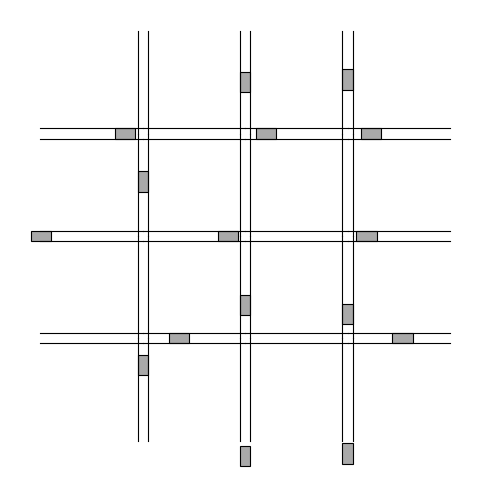

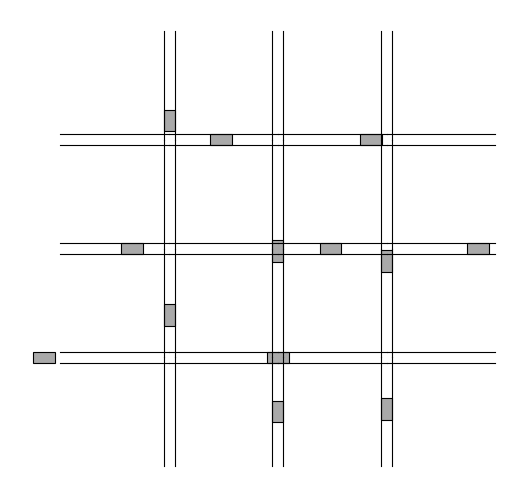

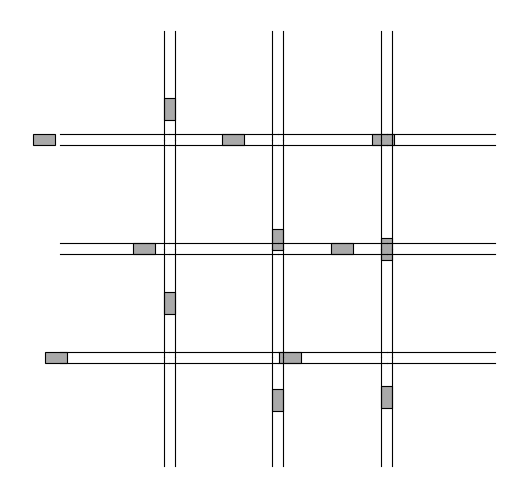

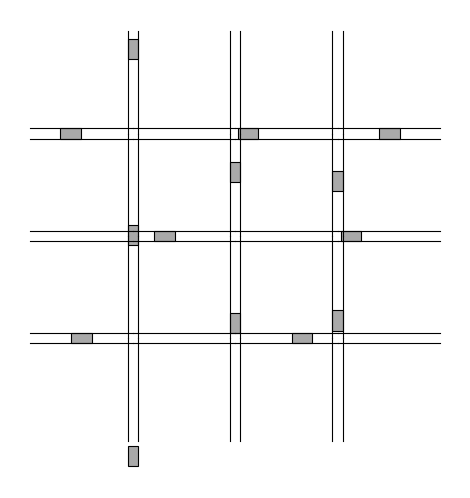

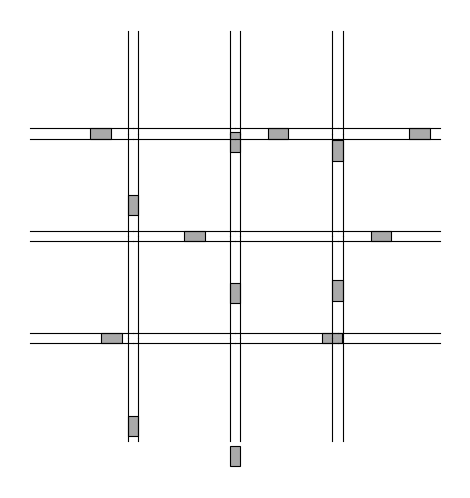

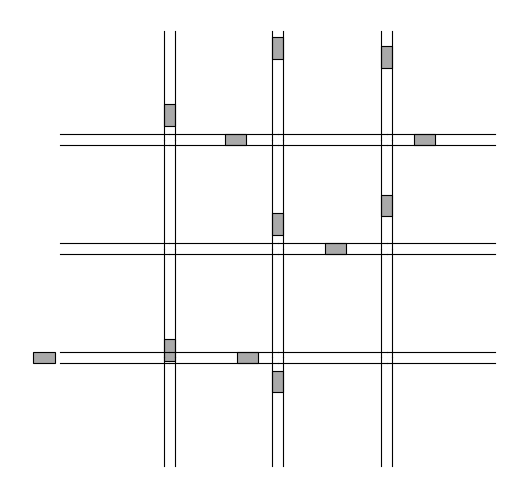

done


In [6]:
from network.util import indexed_arrivals

arrivals = indexed_arrivals(instance)

# partial instance with subset of vehicles visible
instance_part = {
    'G': instance['G'],
    'route': instance['route'],
    'switch': instance['switch'],
    'length': [[] for _ in range(N)],
}

t = 0
positions = {}
y = {}
for arrival in arrivals:
    l, k, r = arrival
    # update positions by simulating the current schedule until r
    simulate(G, routes, y, positions, r-t)        
    # add newly arrived vehicle to the network
    instance_part['length'][l].append(instance['length'][l][k])
    positions[l, k] = 0
    # re-optimize with the new arrival
    y, _ = solve_online(instance_part, positions)

    draw_vehicles(G, routes, positions);
    t = r
print('done')